# Failed rifting and fast drifting: a state-of-the-art compilation of the Logan Loop and Keweenawan Track

This notebook contains code and visualizations associated with the following paper:

Swanson-Hysell, N.L., Ramenzani, J., Fairchild, L.M. and Rose, I., **Failed rifting and fast drifting: Midcontinent Rift development, Laurentia's rapid motion and the driver of Grenvillian orogenesis**, *Geological Society of America Bulletin*, doi:10.1130/B31944.1.

Corresponding Author: Nicholas L. Swanson-Hysell (swanson-hysell@berkeley.edu)

# Introduction

This Jupyter notebook developed using a Python 3.6 kernel contains a compilation and analysis of the apparent polar wander path of the continent of Laurentia (cratonic North America) from ca. 1110 Ma to ca. 1085 Ma. The apex of this path has long been known as the Logan Loop after the Logan Sills of Ontario. From the apex of the Logan Loop, the poles continue on a path that has been referred to as the Keweenawan Track given that the majority of the poles come from the Keweenawan Midcontinent Rift. 

In this analysis, we calculate paleomagnetic poles as the mean of virtual geomagnetic poles (VGP) where each VGP is a single igneous cooling unit. For some data sets, VGPs were provided in the original publication, while in other cases they need to be calculated from the available data. Having the data at the VGP level allows for a robust mean and associated 95% confidence ellipse (A$_{95}$) to be calculated using Fisher statistics. The main text provides the rationale for favoring this approach over calculating the mean in directional space and its associated $\alpha_{95}$ error in directional space and than transforming the error ellipse to pole space where it is expressed with a semi-minor and semi-major axis (dp/dm).

# Import libraries for data analysis

This code blocks imports necessary libraries and defines functions that will be used in the data analysis below. The code below  the pmag.py and ipmag.py modules of the the PmagPy software package (https://github.com/PmagPy/PmagPy). The other modules are currently included with standard scientific python distributions.

In [1]:
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
from IPython.core.display import HTML
import numpy as np
import scipy as sp
from scipy import special
import warnings
warnings.filterwarnings('ignore')

In [2]:
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature


Laurentia_outline = ShapelyFeature(Reader('../data/data_compiled/Laurentia_shape/Laurentia.shp').geometries(),
                                ccrs.PlateCarree(), facecolor = 'none', edgecolor='black')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %conda install mpltoolkits

Let's create an empty dataframe that will be populated with pole means called 'pole_means'.

<b>PoleName | SLat | SLon | PLat | Plon | A95 | PolarityZone | PmagRef | AgeNominal | AgeLower | AgeUpper | AgeInfo | Q  </b>

<b>Pole_name</b> = Name of pole which corresponds to volcanic group <br>
<b>SLat</b> = Sample area decimal latitude (e.g. -56.2)<br>
<b>SLon</b> = Sample area decimal longitude (e.g. 134.8)<br>
<b>PLat</b> = Palaeomagnetic pole decimal latitude (e.g. -56.2)<br>
<b>PLon</b> = Palaeomagnetic pole decimal longitude (e.g. 134.8)<br>
<b>A95</b> = 95% confidence limit on pole in degrees (e.g. 6.2)<br>
<b>k</b> = Fisher precision parameter (e.g. 42.5)<br>
<b>N</b> = Number of VGPs used to calculate the mean<br>
<b>PolarityZone</b> = Assigned polarity zone<br>
<b>AgeNominal</b> = Mean / representative age of sampled formation (e.g. 1105.1)<br>
<b>AgeLower</b> = Estimate lower bound on age uncertainty (e.g. 1103.2)<br>
<b>AgeUpper</b> = Estimate upper bound on age uncertainty (e.g. 1107.4)<br>
<b>Gaussian_2sigma</b> = 2sigma error if Gaussian Distribution is to be used<br>
<b>GaussianOrUniform</b> = Distribution type used for Bayesian inversion<br>
<b>Q</b> = Van der Voo quality criteria (0 - 7)<br>

In [4]:
pole_means = pd.DataFrame(columns=['PoleName','SLat','SLon','PLat','PLon',
                                   'A95','K','N','PolarityZone','PmagRef',
                                   'AgeNominal','AgeLower','AgeUpper',
                                   'AgeInfo','AgeRef','Gaussian_2sigma',
                                   'GaussianOrUniform','Q','color'])

# Data compilation for the North Shore Volcanic Group


## North Shore Volcanic Group and Schroeder-Lutsen Basalts

Tauxe and Kodama (2009) published data from sites of the North Shore Volcanic Group that was the first study of the North Shore Volcanic Group to publish data from these lava flows using modern methods. Books (1968, 1972) and Palmer (1970) also developed data that can largely be considered to be superseded by the Tauxe and Kodama results. However, we will consider some of the Books data from the Grand Portage basalts since only one of those flows was sampled by Tauxe and Kodama (2009) and the generally single component remanence of these lava flows makes it such that the single AF cleaning step methods of those researchers likely isolated robust site means. The Tauxe data can be unpacked from the MagIC contribution and be imported into a dataframe.

### Import Tauxe and Kodama (2009)

Tauxe, L. and Kodama, K., 2009, Paleosecular variation models for ancient times: Clues from Keweenawan lava flows: Physics of the Earth and Planetary Interiors, vol. 177, pp. 31–45, doi:10.1016/j.pepi.2009.07.006.

Link to MagIC contribution: http://earthref.org/MAGIC/doi/j.pepi.2009.07.006

In [5]:
%%capture
ipmag.download_magic('zmab0099887tmp01.txt',
                     dir_path='../data/data_compiled/Tauxe2009',
                     input_dir_path='../data/data_compiled/Tauxe2009',
                     overwrite=True,print_progress=False)

In [6]:
NSVG_Data=pd.read_csv('../data/data_Compiled/Tauxe2009/pmag_results.txt',sep='\t',skiprows=1)

#### Assign Tauxe and Kodama (2009) sites to lava sequences

There are a few sites from intrusive units within the Tauxe and Kodama (2009) data set. Sites ns027 and ns029 are from the Brule Lake Hovland Gabbro. ns025 is from the Monker River Diabase. ns041 is from the Stony Point Diabase. The focus here is on extrusive flows so let's split the data into groups related to the sequence of lava flows they are from using the terminology from Minnesota Geological Survey mapping (Duluth Complex overviewmap). The sequence codes are as follows:

- 'nnel' is the lower northeast sequence of the North Shore Volcanic Group
- 'nneu' is the upper northeast sequence of the North Shore Volcanic Group
- 'nswu' is the upper southwest sequence of the North Shore Volcanic Group
- 'nsl' is the Schroeder-Lutsen basalts above the North Shore Volcanic Group

These codes are assigned to the sites in the code cell below. 

In [7]:
nnel_site_list = ['ns024',
                  'ns026']
nneu_site_list = ['ns002',
                  'ns003',
                  'ns004',
                  'ns005',
                  'ns016',
                  'ns018',
                  'ns019',
                  'ns020',
                  'ns021',
                  'ns022',
                  'ns023',
                  'ns028',
                  'ns030',
                  'ns031',
                  'ns032']
nswu_site_list = ['ns034',
                  'ns035',
                  'ns036',
                  'ns037',
                  'ns038',
                  'ns039',
                  'ns040',
                  'ns042',
                  'ns043',
                  'ns044',
                  'ns045',
                  'ns046',
                  'ns047',
                  'ns048',
                  'ns049',
                  'ns050',
                  'ns051',
                  'ns052',
                  'ns053',
                  'ns054',
                  'ns055',
                  'ns056',
                  'ns057',
                  'ns058',
                  'ns059',
                  'ns060',
                  'ns061',
                  'ns062',
                  'ns063',
                  'ns064',
                  'ns065',
                  'ns066',
                  'ns067',
                  'ns068',
                  'ns071',
                  'ns072',
                  'ns073',
                  'ns074',
                  'ns075',
                  'ns077',
                  'ns078',
                  'ns079',
                  'ns080',
                  'ns081',
                  'ns083',
                  'ns085',
                  'ns087']
nsl_site_list = ['ns006',
                 'ns007',
                 'ns008',
                 'ns009',
                 'ns010',
                 'ns011',
                 'ns012',
                 'ns013',
                 'ns014',
                 'ns015']

nnel_data = NSVG_Data.loc[NSVG_Data['er_site_names'].isin(nnel_site_list)]
nneu_data = NSVG_Data.loc[NSVG_Data['er_site_names'].isin(nneu_site_list)]
nswu_data = NSVG_Data.loc[NSVG_Data['er_site_names'].isin(nswu_site_list)]
nsl_data = NSVG_Data.loc[NSVG_Data['er_site_names'].isin(nsl_site_list)]

### NSVG Southwest Sequence

In addition to assigning sequences, these sites can be divided into the lithostratigraphic units described in Green et al. 2011 that are used in maps of the Minnesota Geological Survey such as GEOLOGIC MAP OF THE DULUTH COMPLEX AND RELATED ROCKS, NORTHEASTERN MINNESOTA (Miller et al., 2001) as well as the more detailed quadrangles. The codes of those map are used here as follows.

- 'nlwb' is the Lakewood Basalts of the upper southwest sequence
- 'nsrb' is the Sucker River Basalts of the upper southwest sequence
- 'nlmb' is the Larsmont Basalts of the upper southwest sequence 
- 'nthb' is the Two Harbors Basalts of the upper southwest sequence

*Note that there are no sites from Tauxe and Kodama (2009) within the following lithostratigraphic units of the upper Southwest Sequence: Leif Erickson Park lavas, Lakeside lavas, Gooseberry River Basalts, Belmore Bay lavas.*

- 'ngpb' is the Grand Portage Basalts of the lower northeast sequence
- 'ndba' is the Deronda Bay Andesite of the lower northeast sequence
- 'nmil' is the Marr Island Lavas of the upper northeast sequence
- 'nkcr' is the Kimball Creek felsites of the upper northeast sequence
- 'nrcb' is the Red Cliff basalts of the upper northeast sequence
- 'ncvb' is the Croftville basalts of the upper northeast sequence
- 'nbwb' is the Breakwater basalts of the upper northeast sequence
- 'ngha' is the Good Harbor Bay andesites of the upper northeast sequence
- 'ntpb' is the Terrace Point basalt flow of the upper northeast sequence
- 'norl'is the Onion River lavas of the upper northeast sequence

In [8]:
nneu_nlwb_sites = ['ns053',
                   'ns055',
                   'ns057',
                   'ns060',
                   'ns061',
                   'ns062',
                   'ns063',
                   'ns064',
                   'ns065',
                   'ns066',
                   'ns067',
                   'ns068',
                   'ns071',
                   'ns072',
                   'ns073',
                   'ns074',
                   'ns075',
                   'ns077',
                   'ns078',
                   'ns079',
                   'ns080',
                   'ns081',
                   'ns083',
                   'ns085',
                   'ns087']
        
nswu_nsrb_sites =  ['ns040',
                    'ns042',
                    'ns043',
                    'ns044',
                    'ns045',
                    'ns046',
                    'ns047',
                    'ns048',
                    'ns049',
                    'ns050',
                    'ns051',
                    'ns052',
                    'ns054',
                    'ns056',
                    'ns058',
                    'ns059']

nswu_nlmb_sites = ['ns038',
                   'ns039']

nswu_nthb_sites = ['ns034',
                   'ns035',
                   'ns036',
                   'ns037']

#Brule_Lake_Hovland_Gabbro
bhrd = ['ns027']
nnel_ngpb_sites = ['ns024']
nnel_ndba_sites = ['ns026']
nneu_nmil_sites = ['ns030']
nneu_nkcr_sites = ['ns022']
nneu_nrcb_sites = ['ns020',
                   'ns023',
                   'ns018',
                   'ns021']
nneu_ncvb_sites = ['ns031',
                   'ns028']
nneu_nbwb_sites = ['ns016',
                   'ns019']
nneu_ngha_sites = ['ns003',
                   'ns002',
                   'ns004',
                   'ns032']
nneu_ntpb_sites = ['ns005']

### Import Books (1968)

The study of Books (1968) developed data from the Powder Mill Group and the Grand Portage Basalts. In this compilation, we have developed a MagIC database contribution for the Books (1968) data. The VGPs were not reported in the study. The code below imports a version of the MagIC contribution without the VGPs and calculates the VGPs using the ipmag.vgpcalc() function. These calculated VGPs were added to the Books (1968) dataset and included in the MagIC contribution that we uploaded.

Books, K., 1968, Magnetization of the lowermost Keweenawan lava flows in the Lake Superior area, Geological Survey research 1968, chapter D: U.S. Geological Survey Professional Paper, vol. P 0600-D, pp. 248–254.

Link to MagIC contribution: http://earthref.org/MagIC/11860

In [9]:
Books1968 = pd.read_csv('../data/data_Compiled/Books1968/Books1968.txt',sep='\t',skiprows=10)
ipmag.vgp_calc(Books1968,site_lon='lon',site_lat='lat',
               dec_tc='dir_dec',inc_tc='dir_inc')
Books1968.vgp_lat = Books1968.vgp_lat_rev
Books1968.vgp_lon = Books1968.vgp_lon_rev
#Books1968.to_csv('../Data_Compiled/Books1968/Books1968_vgps.csv')

In [10]:
%%capture
ipmag.download_magic('Books1968_MagIC.txt',
                     dir_path='../data/data_compiled/Books1968',
                     input_dir_path='../data/data_compiled/Books1968',
                     overwrite=True,print_progress=False)

In [11]:
Books1968_sites = pd.read_csv('../data/data_compiled/Books1968/sites.txt',sep='\t',header=1)
Books1968_ngpb_sites = Books1968_sites[Books1968_sites.location == 'Grand Portage']

### Import Books (1972)

The study of Books (1972) developed data from throughout the Lake Superior region including the upper northeast sequence of the North Shore Volcanic Group.

Books, K., 1972, Paleomagnetism of some Lake Superior Keweenawan rocks: U.S. Geological Survey Professional Paper, vol. P 0760, p. 42.

In [12]:
%%capture
ipmag.download_magic('Books1972_MagIC.txt',
                     dir_path='../data/data_compiled/Books1972',
                     input_dir_path='../data/data_compiled/Books1972',
                     overwrite=True,print_progress=False)

In [13]:
Books1972_sites = pd.read_csv('../data/data_compiled/Books1972/sites.txt',sep='\t',header=1)
Books1972_MN_sites = Books1972_sites[Books1972_sites.location == 'North Shore Volcanic Group:Minnesota']

The Books 1972 sites can be divided by lithostratigraphic unit using the same codes as above.

In [14]:
nneu_nmil_sites_B72 = ['NS269','NS378','NS227']
nneu_nkcr_sites_B72 = ['NS229','NS375']
nneu_nrcb_sites_B72 = ['NS226']
nneu_ncvb_sites_B72 = ['NS362','NS365']
nneu_ngha_sites_B72 = ['NS367','NS265']
nneu_ntpb_sites_B72 = ['NS368',
                       'NS369',
                       'NS374',
                       'NS376',
                       'NS377',
                       'NS169',
                       'NS170',
                       'NS171']
#Note that the Terrace Point Basalt is a single flow
nneu_norl_sites_B72 = ['NS370',
                       'NS371',
                       'NS372']
nsl_sites_B72 = ['NS264',
                 'NS257',
                 'NS258',
                 'NS259',
                 'NS260',
                 'NS261',
                 'NS262',
                 'NS263',
                 'NS256',
                 'NS255',
                 'NS254',
                 'NS379',
                 'NS380',
                 'NS381',
                 'NS382']

nneu_B72_site_list = nneu_nmil_sites_B72 + nneu_nkcr_sites_B72 + nneu_nrcb_sites_B72 + nneu_ncvb_sites_B72 + nneu_ngha_sites_B72 + nneu_norl_sites_B72 
nneu_data_B72 = Books1972_MN_sites.loc[Books1972_MN_sites['site'].isin(nneu_B72_site_list)]
nsl_data_B72 = Books1972_MN_sites.loc[Books1972_MN_sites['site'].isin(nsl_sites_B72)]

Given that the Terrace Point Basalt is a single flow and that Tauxe and Kodama (2009) also developed data from this flow, these data are not included in the upper Northeast sequence sites.

### Import Fairchild et al. (2017)

Fairchild et al. (2017) developed data from Schroeder-Lutsen Basalt flows along the Two Island River in northern Minnesota that can be combined with data from Tauxe and Kodama (2009) in order to develop a pole for the Schroeder-Lutsen Basalts. This study also developed data for the Michipicoten Island Formation which are used below.

Fairchild, L. M., Swanson-Hysell, N. L., Ramezani, J., Sprain, C. J., and Bowring, S. A., 2017, The end of Midcontinent Rift magmatism and the paleogeography of Laurentia: Lithosphere, vol. 9, pp. 117–133, doi:10.1130/L580.1.

Link to MagIC contribution: http://earthref.org/MAGIC/doi/10.1130/L580.1

In [15]:
%%capture
ipmag.download_magic('magic_contribution_11883.txt',
                     dir_path='../data/data_compiled/Fairchild2017',
                     input_dir_path='../data/data_compiled/Fairchild2017',
                     overwrite=True,print_progress=False,data_model=3.0)
Fairchild2017_sites = pd.read_csv('../data/data_compiled/Fairchild2017/sites.txt',sep='\t',header=1)

In [16]:
Fairchild2017_SLB = Fairchild2017_sites[Fairchild2017_sites['location'] == 'Two Island River']
Fairchild2017_SLB = Fairchild2017_SLB[Fairchild2017_SLB['dir_comp_name'] == 'mag']
Fairchild2017_SLB = Fairchild2017_SLB[Fairchild2017_SLB['dir_tilt_correction'] == 100.0]

### North Shore Volcanic Group northeast limb poles

#### Grand Portage Basalts Pole

The Grand Portage Basalts are reversed polarity lava flows in the lower portion of the lower northeast sequence of the North Shore Volcanic Group and are stratigraphically below the Red Rock Rhyolite. The Tauxe and Kodama (2009) data include one flow from the Grand Portage Basalts (ns024) and data from the overlying Deronda Bay Andesite (ns026) that is the flow below the  Red Rock Rhyolite and will be included here in the Grand Portage mean. Data from these flows are combined with the Grand Portage Basalt data from the Books (1968) study.

We have developed a new U-Pb date from the Red Rock Rhyolite which provides an age of 1105.60 +/- 0.32 Ma. This age provides a minimum age constraint on the pole and it is likely close to the absolute pole age. 

In [17]:
Books1968_vgps = ipmag.make_di_block(Books1968_ngpb_sites.vgp_lon.tolist(),
                                     Books1968_ngpb_sites.vgp_lat.tolist())
NSVG_nnel_vgps_r = ipmag.make_di_block(nnel_data.vgp_lon.tolist(),
                                     nnel_data.vgp_lat.tolist())
NSVG_nnel_vgps = ipmag.do_flip(di_block=NSVG_nnel_vgps_r)
Grand_Portage_vgps = Books1968_vgps + NSVG_nnel_vgps
Grand_Portage_mean=pmag.fisher_mean(Grand_Portage_vgps)
ipmag.print_pole_mean(Grand_Portage_mean)

Plon: 201.7  Plat: 46.0
Number of directions in mean (n): 13
Angular radius of 95% confidence (A_95): 6.8
Precision parameter (k) estimate: 38.3


In [18]:
pole_means.loc['Grand Portage Basalts'] = pd.Series({'PoleName' : 'Grand Portage Basalts',
                                        'SLat' : 47.93,
                                        'SLon' : 270.28,
                                        'PLat' : round(Grand_Portage_mean['inc'],1),
                                        'PLon' : round(Grand_Portage_mean['dec'],1),
                                        'A95' : round(Grand_Portage_mean['alpha95'],1),
                                        'K' : round(Grand_Portage_mean['k'],1),
                                        'N' : int(Grand_Portage_mean['n']),
                                        'PolarityZone' : 'Alona Bay reversed-polarity zone',
                                        'PmagRef' : 'Books, 1968; Tauxe and Kodama, 2009',
                                        'AgeNominal' : 1106,
                                        'AgeLower' : 1105.28,
                                        'AgeUpper' : 1108,
                                        'AgeInfo' : 'Close to, but slightly older than, $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U 1105.60 $\pm$ 0.32 Ma based on date from Red Rock Rhyolite',
                                        'AgeRef' : 'this study',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '5',
                                        'color' : '#E0785F'})

#### North Shore Volcanic Group upper northeast limb pole

In [19]:
nneu_combined_vgp_lon = nneu_data_B72.vgp_lon.tolist() + nneu_data.vgp_lon.tolist()
nneu_combined_vgp_lat = nneu_data_B72.vgp_lat.tolist() + nneu_data.vgp_lat.tolist()


nneu_VGPs = ipmag.make_di_block(nneu_combined_vgp_lon,
                                nneu_combined_vgp_lat)
nneu_mean=pmag.fisher_mean(nneu_VGPs)
ipmag.print_pole_mean(nneu_mean)

Plon: 181.7  Plat: 31.1
Number of directions in mean (n): 28
Angular radius of 95% confidence (A_95): 4.2
Precision parameter (k) estimate: 42.2


In [20]:
nneu_combined_dir_dec = nneu_data_B72.dir_dec.tolist() + nneu_data.average_dec.tolist()
nneu_combined_dir_inc = nneu_data_B72.dir_inc.tolist() + nneu_data.average_inc.tolist()


nneu_dirs = ipmag.make_di_block(nneu_combined_dir_dec,
                                nneu_combined_dir_inc)
nneu_dir_mean=pmag.fisher_mean(nneu_dirs)
ipmag.print_direction_mean(nneu_mean)

Dec: 181.7  Inc: 31.1
Number of directions in mean (n): 28
Angular radius of 95% confidence (a_95): 4.2
Precision parameter (k) estimate: 42.2


In [72]:
nneu_data_combined_site_lon=nneu_data_B72.lon.tolist()+nneu_data.average_lon.tolist()
nneu_data_combined_site_lat=nneu_data_B72.lat.tolist()+nneu_data.average_lat.tolist()
nneu_lat_lon=nneu_data_combined_site_lon+nneu_data_combined_site_lat


In [79]:
nneu_lat_lon

[-90.77224503,
 -90.77325863,
 -90.77244775,
 -90.43604193,
 -90.42501636,
 -90.33460283,
 -90.26737951,
 -90.20147585,
 -90.17323865,
 -90.13329374,
 -90.10516022,
 -90.09270441,
 -90.0612863,
 269.5708,
 269.5886,
 269.5637,
 269.557,
 269.6176,
 269.7907,
 269.6094,
 269.8093,
 269.7795,
 269.8714,
 269.79900000000004,
 269.6682,
 269.8944,
 269.6691,
 269.5571,
 47.60965688,
 47.61075345,
 47.61006809,
 47.73256813,
 47.73453979,
 47.76532723,
 47.76702215,
 47.77600067,
 47.78890296,
 47.79577622,
 47.79860756,
 47.80570607,
 47.822107,
 47.7341,
 47.7371,
 47.7328,
 47.7254,
 47.743,
 47.7767,
 47.7417,
 47.7786,
 47.7771,
 47.7965,
 47.7763,
 47.7671,
 47.799,
 47.7689,
 47.7319]

In [21]:
nneu_data_B72.head()

,citations,dir_dec,dir_inc,dir_n_samples,dir_polarity,dir_tilt_correction,formation,geologic_classes,geologic_types,lat,lithologies,location,lon,method_codes,result_type,site,site_alternatives,vgp_lat,vgp_lon
110,This study,285.0,54.2,5,n,100,NaN,Extrusive,Lava Flow,47.609657,Basalt,North Shore Volcanic Group:Minnesota,-90.772245,LT-AF-Z,a,NS370,Onion River lavas,34.346366,195.186906
112,This study,288.8,43.3,4,n,100,NaN,Extrusive,Lava Flow,47.610753,Basalt,North Shore Volcanic Group:Minnesota,-90.773259,LT-AF-Z,a,NS372,Onion River lavas,30.753380,184.035032
114,This study,285.2,41.6,4,n,100,NaN,Extrusive,Lava Flow,47.610068,Basalt,North Shore Volcanic Group:Minnesota,-90.772448,LT-AF-Z,a,NS371,Onion River lavas,27.466210,185.474423
131,This study,286.0,47.2,3,n,100,NaN,Extrusive,Lava Flow,47.732568,Basalt,North Shore Volcanic Group:Minnesota,-90.436042,LT-AF-Z,a,NS265,Good Harbor Bay andesite,30.978886,188.967173
132,This study,285.5,56.0,5,n,100,NaN,Extrusive,Lava Flow,47.734540,Andesite,North Shore Volcanic Group:Minnesota,-90.425016,LT-AF-Z,a,NS367,Good Harbor Bay andesite,35.809202,196.910574


In [22]:
nneu_data.head()

,average_alpha95,average_dec,average_inc,average_k,average_lat,average_lon,average_n,average_nn,average_r,data_type,er_citation_names,er_location_names,er_site_names,er_specimen_names,magic_method_codes,magic_software_packages,pmag_criteria_codes,pmag_result_name,tilt_correction,vgp_dm,vgp_dp,vgp_lat,vgp_lon,vgp_n
0,6.6,283.5,38.7,192.0,47.7341,269.5708,4,4,3.9844,i,This study,North Shore Volcanics,ns002,ns002b1 : ns002c1 : ns002d1 : ns002f1,DE-FM : DE-DI,pmagpy-2.03,DE-SITE,VGP: Site ns002,100,5.7,8.7,24.9,185.2,4
1,3.8,286.9,47.9,412.9,47.7371,269.5886,5,5,4.9903,i,This study,North Shore Volcanics,ns003,ns003a1 : ns003b1 : ns003d2 : ns003e1 : ns003f1,DE-FM : DE-DI,pmagpy-2.03,DE-SITE,VGP: Site ns003,100,3.8,5.0,32.0,188.9,5
2,5.6,290.0,47.8,186.1,47.7328,269.5637,5,5,4.9785,i,This study,North Shore Volcanics,ns004,ns004a1 : ns004c1 : ns004e1 : ns004f1 : ns004g1,DE-FM : DE-DI,pmagpy-2.03,DE-SITE,VGP: Site ns004,100,5.6,7.4,34.0,186.7,5
3,5.3,299.8,37.6,298.6,47.7254,269.5570,4,4,3.9900,i,This study,North Shore Volcanics,ns005,ns005b1 : ns005c1 : ns005e1 : ns005g1,DE-FM : DE-DI,pmagpy-2.03,DE-SITE,VGP: Site ns005,100,4.5,7.0,35.3,172.4,4
14,9.3,277.0,56.1,72.7,47.7430,269.6176,5,5,4.9518,i,This study,North Shore Volcanics,ns016,ns016a1 : ns016b1 : ns016c1 : ns016e2 : ns016f1,DE-FM-LP : DE-DI,pmagpy-2.03,DE-SITE,VGP: Site ns016,100,11.2,12.3,30.5,202.1,5


In [23]:
pole_means.loc['NSVG_nneu'] = pd.Series({'PoleName' : 'North Shore Volcanic Group (upper NE sequence)',
                                        'SLat' : round(nneu_data_B72.lat.tolist()[0],2),
                                        'SLon' : 360+round(nneu_data_B72.lon.tolist()[0],2),
                                        'PLat' : round(nneu_mean['inc'],1),
                                        'PLon' : round(nneu_mean['dec'],1),
                                        'A95' : round(nneu_mean['alpha95'],1),
                                        'K' : round(nneu_mean['k'],1),
                                        'N' : int(nneu_mean['n']),
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Books, 1972; Tauxe and Kodama, 2009',
                                        'AgeNominal' : 1095,
                                        'AgeLower' : 1092,
                                        'AgeUpper' : 1098,
                                        'AgeInfo' : "Younger than the the Devil's Kettle Rhyolite $^{\mathrm{207}}$Pb/$^{\mathrm{206}}$Pb date of 1097.7 $\pm$ 2.2 Ma, the new $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U 1093.38 $\pm$ 0.55 Ma date from the Grand Marais Rhyolite is near the top of the sequence with paleomagnetic data",
                                        'AgeRef' : 'Davis and Green, 1997; Fairchild et al., 2017',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '6',
                                        'color' : '#35474E'})

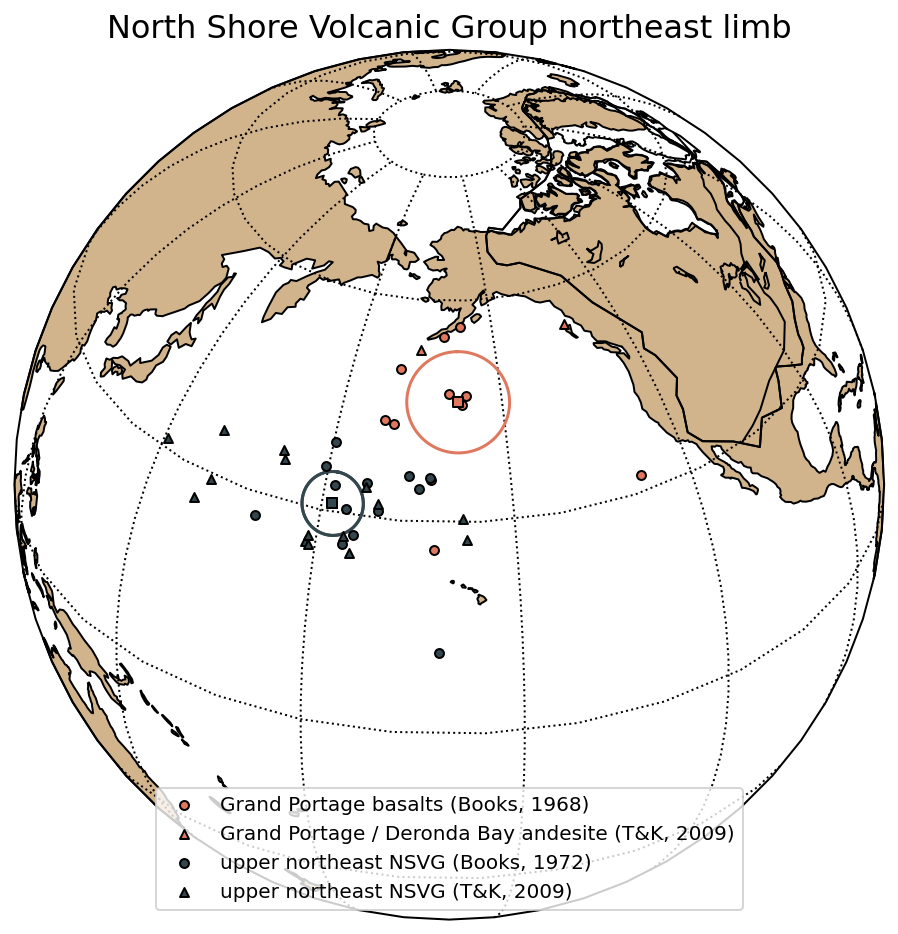

In [24]:
m=ipmag.make_orthographic_map(central_longitude=200,central_latitude=35)

ipmag.plot_vgp(m,Books1968_ngpb_sites.vgp_lon.tolist(),
               Books1968_ngpb_sites.vgp_lat.tolist(),
               color=pole_means['color']['Grand Portage Basalts'],marker='o',
               label='Grand Portage basalts (Books, 1968)')
ipmag.plot_vgp(m,di_block=NSVG_nnel_vgps,
               color=pole_means['color']['Grand Portage Basalts'],marker='^',
               label='Grand Portage / Deronda Bay andesite (T&K, 2009)')
ipmag.plot_pole(m,pole_means['PLon']['Grand Portage Basalts'],
               pole_means['PLat']['Grand Portage Basalts'],
               pole_means['A95']['Grand Portage Basalts'],
               marker='s',color=pole_means['color']['Grand Portage Basalts'],
               edgecolor='k',markersize=30)

ipmag.plot_vgp(m,nneu_data_B72.vgp_lon.tolist(),
               nneu_data_B72.vgp_lat.tolist(),
               color=pole_means['color']['NSVG_nneu'],marker='o',
               label='upper northeast NSVG (Books, 1972)')
ipmag.plot_vgp(m,nneu_data.vgp_lon.tolist(),
               nneu_data.vgp_lat.tolist(),
               color=pole_means['color']['NSVG_nneu'],marker='^',
               label='upper northeast NSVG (T&K, 2009)')
ipmag.plot_pole(m,pole_means['PLon']['NSVG_nneu'],
               pole_means['PLat']['NSVG_nneu'],
               pole_means['A95']['NSVG_nneu'],
               marker='s',color=pole_means['color']['NSVG_nneu'],
               edgecolor='k',markersize=30)
ipmag.plot_pole(m,pole_means['PLon']['NSVG_nneu'],
               pole_means['PLat']['NSVG_nneu'],
               pole_means['A95']['NSVG_nneu'],
               marker='s',color=pole_means['color']['NSVG_nneu'],
               edgecolor='k',markersize=30)
plt.title('North Shore Volcanic Group northeast limb',fontsize=16)
m.add_feature(Laurentia_outline)
#plt.legend(bbox_to_anchor=(1.05, 0.25))
plt.legend(loc=8)
#plt.savefig('./Plots/vgps_NSVG_NE.svg')
plt.show()

In [25]:
pole_means

,PoleName,SLat,SLon,PLat,PLon,A95,K,N,PolarityZone,PmagRef,AgeNominal,AgeLower,AgeUpper,AgeInfo,AgeRef,Gaussian_2sigma,GaussianOrUniform,Q,color
Grand Portage Basalts,Grand Portage Basalts,47.93,270.28,46.0,201.7,6.8,38.3,13,Alona Bay reversed-polarity zone,"Books, 1968; Tauxe and Kodama, 2009",1106,1105.28,1108,"Close to, but slightly older than, $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U 1105.60 $\pm$ 0.32 Ma based on date from Red Rock Rhyolite",this study,NaN,uniform,5,#E0785F
NSVG_nneu,North Shore Volcanic Group (upper NE sequence),47.61,269.23,31.1,181.7,4.2,42.2,28,Portage Lake normal-polarity zone,"Books, 1972; Tauxe and Kodama, 2009",1095,1092.00,1098,"Younger than the the Devil's Kettle Rhyolite $^{\mathrm{207}}$Pb/$^{\mathrm{206}}$Pb date of 1097.7 $\pm$ 2.2 Ma, the new $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U 1093.38 $\pm$ 0.55 Ma date from the Grand Marais Rhyolite is near the top of the sequence with paleomagnetic data","Davis and Green, 1997; Fairchild et al., 2017",NaN,uniform,6,#35474E


In [26]:
print(pole_means['PLon']['NSVG_nneu'],pole_means['PLat']['NSVG_nneu'], pole_means['A95']['NSVG_nneu'])

181.7 31.1 4.2


### North Shore Volcanic Group southwest limb pole

#### Import new Gooseberry Basalts data

In [27]:
GB_Data = pd.read_csv('../data/data_compiled/Gooseberry/sites.txt',sep='\t',skiprows=1)
GB_Data_tc = GB_Data[GB_Data['dir_tilt_correction'] == 100.0]
GB_Data_HT = GB_Data[GB_Data['dir_comp_name'] == 'HT']
GB_Data_HT = GB_Data_HT[GB_Data_HT['dir_tilt_correction'] == 100.0]
GB_Data_HT.head()

,age,age_high,age_low,age_sigma,age_unit,citations,criteria,dir_alpha95,dir_comp_name,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_specimens_lines,dir_n_specimens_planes,dir_polarity,dir_r,dir_tilt_correction,lat,location,lon,method_codes,result_quality,result_type,samples,site,software_packages,specimens,vgp_dm,vgp_dp,vgp_lat,vgp_lon
1,1095.25,1095.8,1094.7,0.55,Years Cal BP,This study,ACCEPT,4.5,HT,299.4,47.9,154,8,8,8,0,n,7.9545,100,47.2,Gooseberry,-91.5,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,GB1-1:GB1-2:GB1-3:GB1-4:GB1-5:GB1-6:GB1-7:GB1-8,GB1,pmagpy-3.8.9-2: demag_gui.v.3.0,GB1-1a:GB1-2a:GB1-3a:GB1-4a:GB1-5a:GB1-6a:GB1-7a:GB1-8a,5.9,3.8,40.3,179.5
3,1095.25,1095.8,1094.7,0.55,Years Cal BP,This study,ACCEPT,2.2,HT,301.1,42.1,466,10,10,10,0,n,9.9807,100,47.1,Gooseberry,-91.5,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,GB10-10:GB10-1:GB10-2:GB10-3:GB10-4:GB10-5:GB10-6:GB10-7:GB10-8:GB10-9,GB10,pmagpy-3.8.9-2: demag_gui.v.3.0,GB10-10a:GB10-1a:GB10-2a:GB10-3a:GB10-4a:GB10-5a:GB10-6a:GB10-7a:GB10-8a:GB10-9a,2.7,1.7,38.5,173.8
5,1095.25,1095.8,1094.7,0.55,Years Cal BP,This study,ACCEPT,4.7,HT,303.2,38.3,168,7,7,7,0,n,6.9643,100,47.1,Gooseberry,-91.5,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,GB11-1:GB11-2:GB11-3:GB11-4:GB11-7:GB11-8:GB11-9,GB11,pmagpy-3.8.9-2: demag_gui.v.3.0,GB11-1a:GB11-2a:GB11-3a:GB11-4a:GB11-7a:GB11-8a:GB11-9a,5.6,3.3,38.0,169.5
7,1095.25,1095.8,1094.7,0.55,Years Cal BP,This study,ACCEPT,1.8,HT,303.0,41.0,1112,7,7,7,0,n,6.9946,100,47.1,Gooseberry,-91.5,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,GB12-1:GB12-2:GB12-3:GB12-5:GB12-6:GB12-7:GB12-8,GB12,pmagpy-3.8.9-2: demag_gui.v.3.0,GB12-1a:GB12-2a:GB12-3a:GB12-5a:GB12-6a:GB12-7a:GB12-8a,2.2,1.3,39.2,171.5
9,1095.25,1095.8,1094.7,0.55,Years Cal BP,This study,ACCEPT,2.0,HT,295.1,42.3,742,8,8,8,0,t,7.9906,100,47.1,Gooseberry,-91.5,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,GB13-1:GB13-2:GB13-3:GB13-4:GB13-5:GB13-6:GB13-7:GB13-8,GB13,pmagpy-3.8.9-2: demag_gui.v.3.0,GB13-1a:GB13-2a:GB13-3a:GB13-4a:GB13-5a:GB13-6a:GB13-7a:GB13-8a,2.5,1.5,34.5,178.4


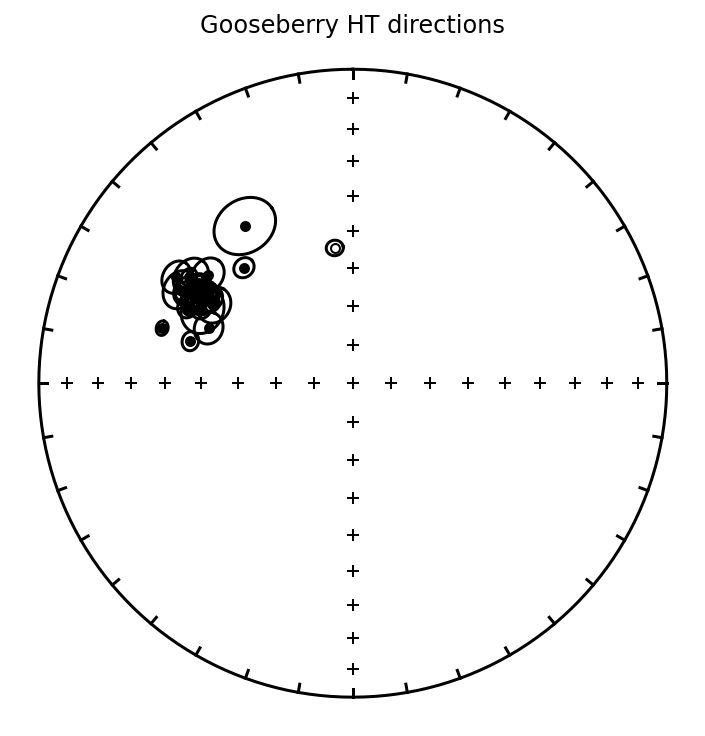

In [28]:
plt.figure(num=1,figsize=(5,5))
ipmag.plot_net(1)

for i in list(GB_Data_HT.index.values):
    ipmag.plot_di_mean(GB_Data_HT['dir_dec'][i], GB_Data_HT['dir_inc'][i],
                       GB_Data_HT['dir_alpha95'][i])
    
plt.title('Gooseberry HT directions')
plt.show()

The site means all form a coherent cluster with the exception of the GB5 site mean which is north and up in orientation rather than NE and down. We interpret this flow to be recording an excursion and therefore exclude it from the calculation of a new pole.

In [29]:
GB_Data_HT_filtered = GB_Data_HT[GB_Data_HT.site != 'GB5']

Plon: 174.9  Plat: 38.4
Number of directions in mean (n): 31
Angular radius of 95% confidence (A_95): 2.3
Precision parameter (k) estimate: 125.8


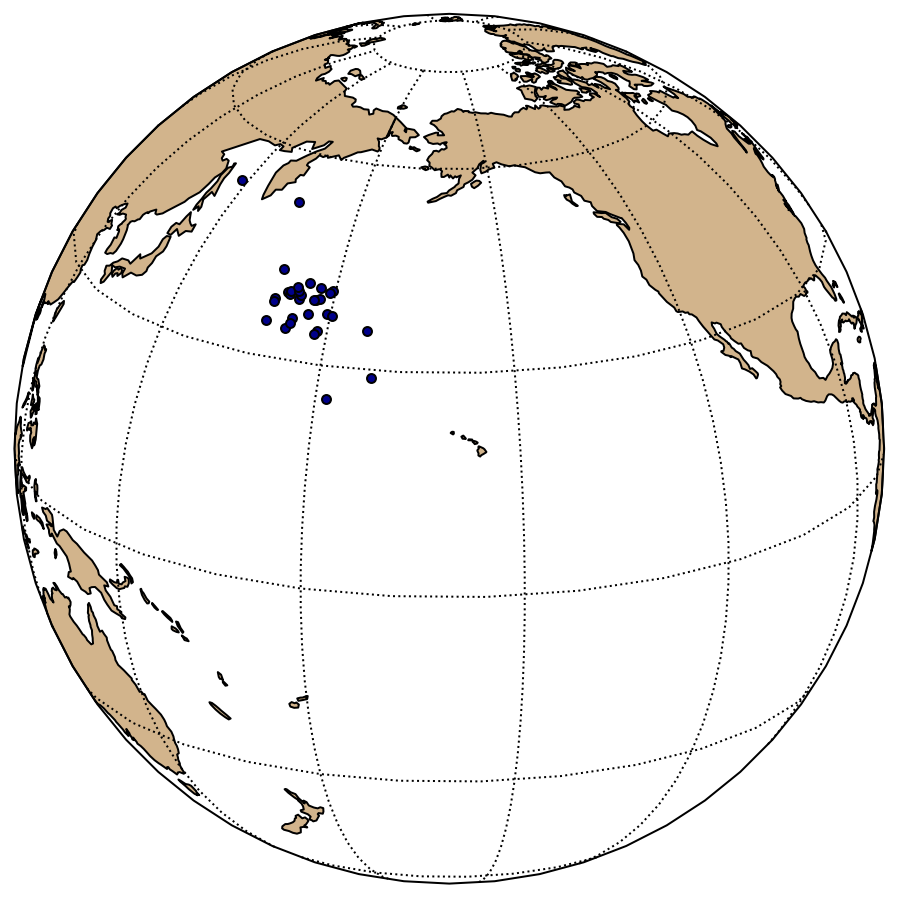

In [30]:
GB_mean_pole = ipmag.fisher_mean(GB_Data_HT_filtered['vgp_lon'].tolist(),GB_Data_HT_filtered['vgp_lat'].tolist())
ipmag.print_pole_mean(GB_mean_pole)

m=ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)

ipmag.plot_vgp(m,GB_Data_HT_filtered['vgp_lon'].tolist(),GB_Data_HT_filtered['vgp_lat'].tolist(),
               color='DarkBlue',label='Gooseberry VGPs')

#### Combine data for North Shore Volcanic Group upper southwest limb pole

The North Shore Volcanic Group (NSVG) is comprised of two main limbs with distinct stratigraphy and radiometric age control. The southwest limb of the NSVG ('nswu') was particularly well-sampled by Tauxe and Kodama (2009) and we now add data from 31 additional flows of the Gooseberry Basalts. All of these sites can be bracketed with U-Pb dates from the Lakewood icelandite and the Palisade rhyolite.

In [31]:
nswu_vgp_lons = nswu_data.vgp_lon.tolist() + GB_Data_HT_filtered.vgp_lon.tolist()
nswu_vgp_lats = nswu_data.vgp_lat.tolist() + GB_Data_HT_filtered.vgp_lat.tolist()

nswu_VGPs = ipmag.make_di_block(nswu_vgp_lons,nswu_vgp_lats)
nswu_mean=pmag.fisher_mean(nswu_VGPs)
ipmag.print_pole_mean(nswu_mean)

Plon: 179.3  Plat: 36.9
Number of directions in mean (n): 78
Angular radius of 95% confidence (A_95): 2.1
Precision parameter (k) estimate: 56.8


In [32]:
pole_means.loc['NSVG_nswu'] = pd.Series({'PoleName' : 'North Shore Volcanic Group (upper SW sequence)',
                                        'SLat' : round(GB_Data_HT.lat.tolist()[0],2),
                                        'SLon' : round((360+GB_Data_HT.lon.tolist()[0]),2),
                                        'PLat' : round(nswu_mean['inc'],1),
                                        'PLon' : round(nswu_mean['dec'],1),
                                        'A95' : round(nswu_mean['alpha95'],1),
                                        'K' : round(nswu_mean['k'],1),
                                        'N' : int(nswu_mean['n']),
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Tauxe and Kodama, 2009; this study',
                                        'AgeNominal' : 1096.18,
                                        'AgeLower' : 1093.94,
                                        'AgeUpper' : 1096.75,
                                        'AgeInfo' : '$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date on 40th Ave. Icelandite (1096.75 $\pm$ 0.28) provides a lower bound, the $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date on the Two Harbors Icelandite is within the sequence (1096.18 $\pm$ 0.32) and the Palisade Rhyolite (1093.94 $\pm$ 0.28) provides an upper bound',
                                        'AgeRef' : 'this study',
                                        'GaussianOrUniform' : 'gaussian',
                                        'Gaussian_2sigma' : round(((1096.18-1093.94)/2),2),
                                        'Q' : '6',
                                        'color' : '#154F8D'})

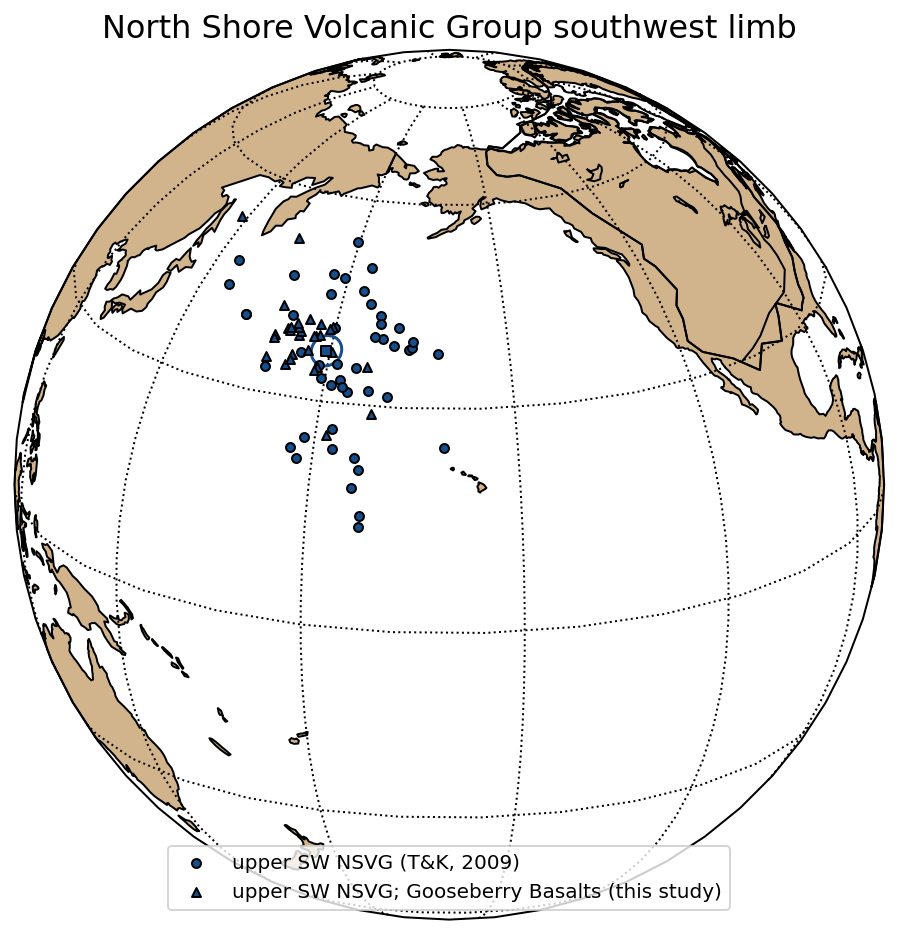

In [33]:
m=ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)

ipmag.plot_vgp(m,nswu_data['vgp_lon'].tolist(),nswu_data['vgp_lat'].tolist(),
               color=pole_means['color']['NSVG_nswu'],label='upper SW NSVG (T&K, 2009)')
ipmag.plot_vgp(m,GB_Data_HT_filtered['vgp_lon'].tolist(),
               GB_Data_HT_filtered['vgp_lat'].tolist(),
               color=pole_means['color']['NSVG_nswu'],marker='^',
               label='upper SW NSVG; Gooseberry Basalts (this study)')
ipmag.plot_pole(m,pole_means['PLon']['NSVG_nswu'],
                pole_means['PLat']['NSVG_nswu'],
                pole_means['A95']['NSVG_nswu'],
                marker='s',color=pole_means['color']['NSVG_nswu'],
                edgecolor='k',markersize=30)

m.add_feature(Laurentia_outline)
#plt.legend(bbox_to_anchor=(1.0, 0.25))
plt.legend(loc=8)
plt.title('North Shore Volcanic Group southwest limb',fontsize=16)
#plt.savefig('./Plots/vgps_NSVG_SW.svg')
plt.show()

###  Schroeder Lutsen Basalts

The pole published for the Schroeder-Lutsen Basalts in Fairchild et al., 2017 combined data from 40 new sites with data from 10 sites within the basalts developed by Tauxe and Kodama (2009).

In [34]:
combined_SLB_lon = nsl_data['vgp_lon'].tolist() + Fairchild2017_SLB['vgp_lon'].tolist()
combined_SLB_lat = nsl_data['vgp_lat'].tolist() + Fairchild2017_SLB['vgp_lat'].tolist()
SLB_pole = ipmag.fisher_mean(combined_SLB_lon,combined_SLB_lat)
ipmag.print_pole_mean(SLB_pole)

Plon: 188.0  Plat: 26.9
Number of directions in mean (n): 50
Angular radius of 95% confidence (A_95): 3.0
Precision parameter (k) estimate: 45.4


In addition to the sites in the pole above, sites were developed by Books (1972) from the Schroeder-Lutsen Basalts that can be added to the pole.

In [35]:
combined_SLB_lon_new = nsl_data['vgp_lon'].tolist() + Fairchild2017_SLB['vgp_lon'].tolist() + nsl_data_B72['vgp_lon'].tolist()
combined_SLB_lat_new = nsl_data['vgp_lat'].tolist() + Fairchild2017_SLB['vgp_lat'].tolist() + nsl_data_B72['vgp_lat'].tolist()
SLB_pole_new = ipmag.fisher_mean(combined_SLB_lon_new,combined_SLB_lat_new)
ipmag.print_pole_mean(SLB_pole_new)

Plon: 187.6  Plat: 28.3
Number of directions in mean (n): 65
Angular radius of 95% confidence (A_95): 2.5
Precision parameter (k) estimate: 50.5


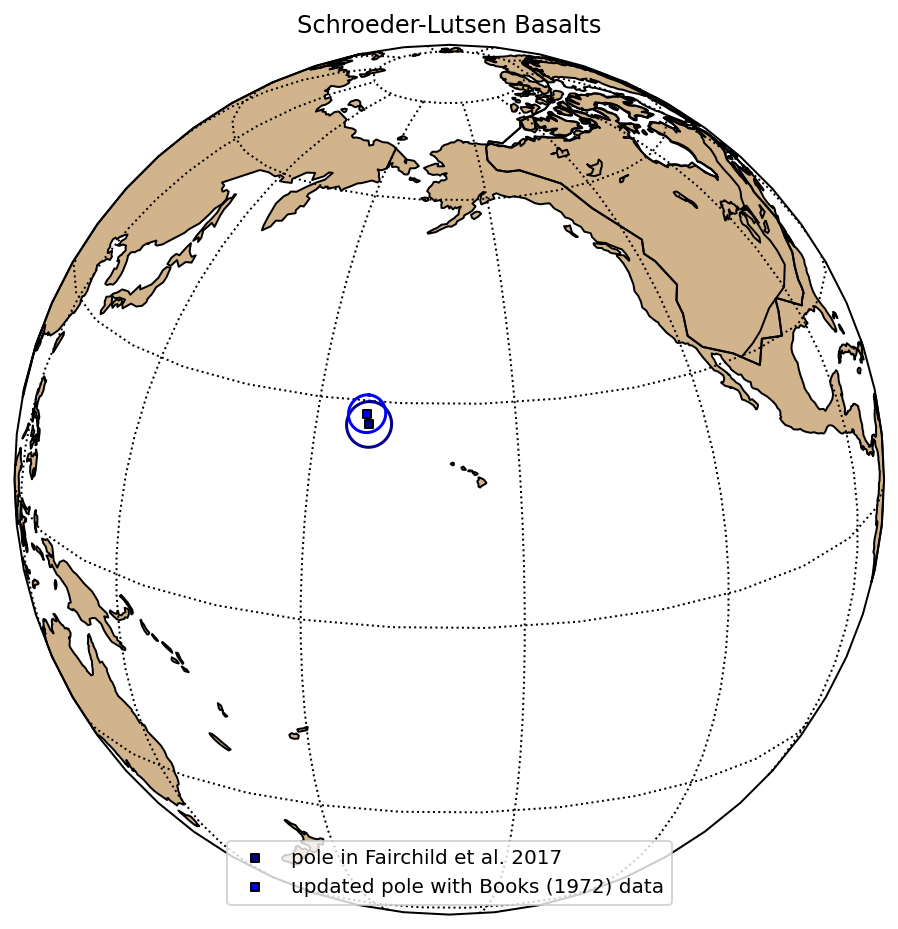

In [36]:
m=ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)

ipmag.plot_pole(m,SLB_pole['dec'],
                SLB_pole['inc'],
                SLB_pole['alpha95'],
                marker='s',color='DarkBlue',
                label='pole in Fairchild et al. 2017')
ipmag.plot_pole(m,SLB_pole_new['dec'],
                SLB_pole_new['inc'],
                SLB_pole_new['alpha95'],
                marker='s',color='Blue',
                label='updated pole with Books (1972) data')
m.add_feature(Laurentia_outline)
plt.legend(loc=8)
plt.title('Schroeder-Lutsen Basalts')
plt.show()

In [37]:
pole_means.loc['SLB'] = pd.Series({'PoleName' : 'Schroeder Lutsen Basalts',
                                        'SLat' : 47.54,
                                        'SLon' : 269.10,
                                        'PLat' : round(SLB_pole_new['inc'],1),
                                        'PLon' : round(SLB_pole_new['dec'],1),
                                        'A95' : round(SLB_pole_new['alpha95'],1),
                                        'K' : round(SLB_pole_new['k'],1),
                                        'N' : int(SLB_pole_new['n']),
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Books, 1972; Tauxe and Kodama, 2009; Fairchild et al., 2017',
                                        'AgeNominal' : 1090,
                                        'AgeLower' : 1085,
                                        'AgeUpper' : 1091.5,
                                        'AgeInfo' : '$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date of of 1091.48 $\pm$ 0.21 Ma on Beaver Bay Complex aplite provides maximum age constraint',
                                        'AgeRef' : 'Fairchild et al., 2017',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '6',
                                        'color' : '#8DC2DC'})

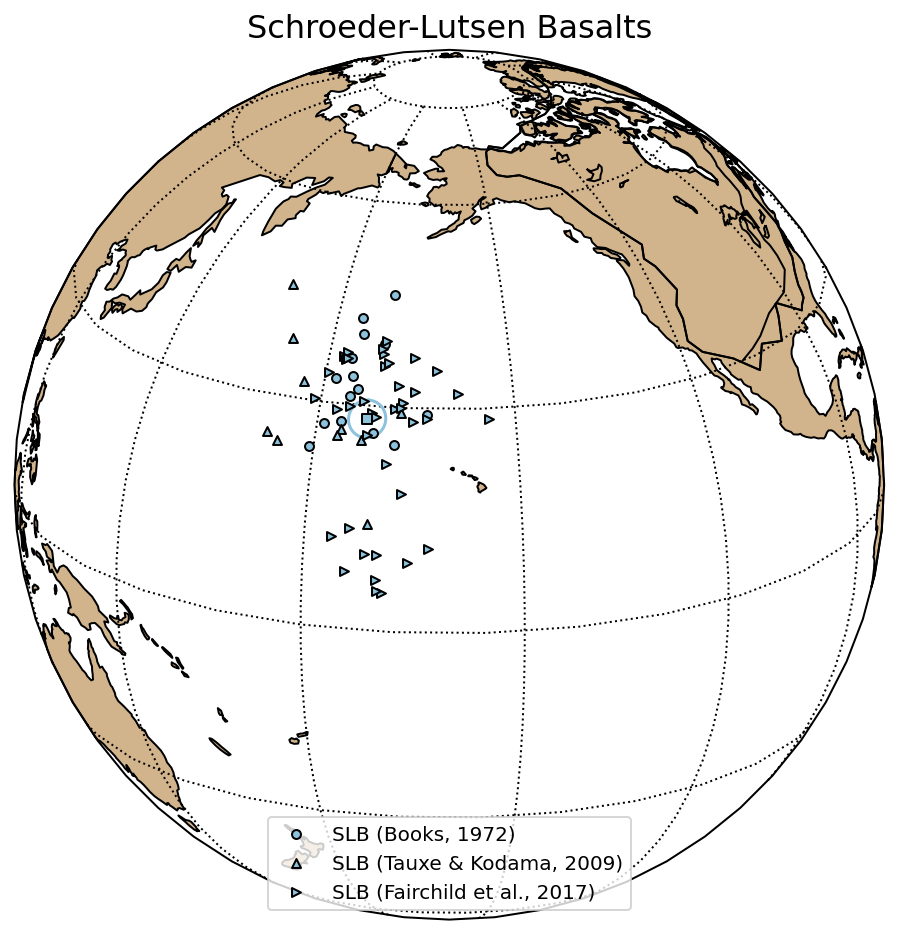

In [38]:
m=ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)

ipmag.plot_vgp(m,nsl_data_B72['vgp_lon'].tolist(),nsl_data_B72['vgp_lat'].tolist(),
               color=pole_means['color']['SLB'],marker='o',label='SLB (Books, 1972)')
ipmag.plot_vgp(m,nsl_data['vgp_lon'].tolist(),nsl_data['vgp_lat'].tolist(),
               color=pole_means['color']['SLB'],marker='^',label='SLB (Tauxe & Kodama, 2009)')
ipmag.plot_vgp(m,Fairchild2017_SLB['vgp_lon'].tolist(),Fairchild2017_SLB['vgp_lat'].tolist(),
               color=pole_means['color']['SLB'],marker='>',label='SLB (Fairchild et al., 2017)')
ipmag.plot_pole(m,pole_means['PLon']['SLB'],
                pole_means['PLat']['SLB'],
                pole_means['A95']['SLB'],
                marker='s',color=pole_means['color']['SLB'],
                edgecolor='k',markersize=30)

m.add_feature(Laurentia_outline)
plt.legend(loc=8)
plt.title('Schroeder-Lutsen Basalts',fontsize=16)
#plt.savefig('./Plots/vgps_SLB.svg')
plt.show()

# References